In [1]:
!pip install ucimlrepo

## Import libraries

import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:


# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets
# Combine features (X) and target (y) into one DataFrame
df = X.copy()
df['y'] = y


#categorical columns
categorical_columns=X.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

#numerical columns
numerical_columns=X.select_dtypes(include=['int64']).columns.tolist()
print(numerical_columns)



['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']


In [17]:
#Handling missing values

#job
df['job'] = df['job'].fillna('unknown')

#education
df['education'] = df['education'].fillna('unknown')

#contact
df['contact'] = df['contact'].fillna('unknown')

#poutcome
df['poutcome'] = df['poutcome'].fillna('unknown')

In [18]:
from sklearn.preprocessing import StandardScaler
# Drop 'duration' for realistic modeling
X = X.drop(columns=['duration'])

# Process 'pdays'
X['pdays_flag'] = (X['pdays'] == -1).astype(int)
X['pdays'] = X['pdays'].replace(-1, 0)

# Optionally scale numeric features
scaler = StandardScaler()
X[['campaign', 'previous']] = scaler.fit_transform(X[['campaign', 'previous']])


#Encoding Categorocal Variables


In [19]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

def encode_features(df):
    """
    Encodes categorical features in the DataFrame using different encoding strategies.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing categorical features.

    Returns:
        pd.DataFrame: The DataFrame with encoded features.
    """
    # 1. One-Hot Encoding for high/moderate cardinality nominal features
    one_hot_features = ['job', 'marital', 'education','contact', 'month','day_of_week' ,'poutcome','education']
    df_one_hot = pd.get_dummies(df[one_hot_features], drop_first=True)



    # 3. Binary Encoding for binary features
    binary_features = ['default', 'housing', 'loan']
    for feature in binary_features:
        df[feature + '_encoded'] = df[feature].map({'no': 0, 'yes': 1})

    # Combine all encoded features
    df_encoded = pd.concat([df.drop(columns=one_hot_features + binary_features), df_one_hot], axis=1)

    return df_encoded




# Call the function
df_encoded = encode_features(df)

# Display the final encoded dataset
print(df_encoded.head())

   age  balance  duration  campaign  pdays  previous   y  default_encoded  \
0   58     2143       261         1     -1         0  no                0   
1   44       29       151         1     -1         0  no                0   
2   33        2        76         1     -1         0  no                0   
3   47     1506        92         1     -1         0  no                0   
4   33        1       198         1     -1         0  no                0   

   housing_encoded  loan_encoded  ...  month_may  month_nov  month_oct  \
0                1             0  ...       True      False      False   
1                1             0  ...       True      False      False   
2                1             1  ...       True      False      False   
3                1             0  ...       True      False      False   
4                0             0  ...       True      False      False   

   month_sep  poutcome_other  poutcome_success  poutcome_unknown  \
0      False           F

##Drop Columns

In [14]:
pip install imbalanced-learn


##Train Model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Class distribution after SMOTE + Tomek:
y
0    31082
1    31082
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1943/1943 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.57      0.52      0.55      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.74      0.74      9043
weighted avg       0.89      0.90      0.90      9043

Stacking Ensemble ROC-AUC Score: 0.9183447697892907
Precision-Recall AUC: 0.5645072537400684


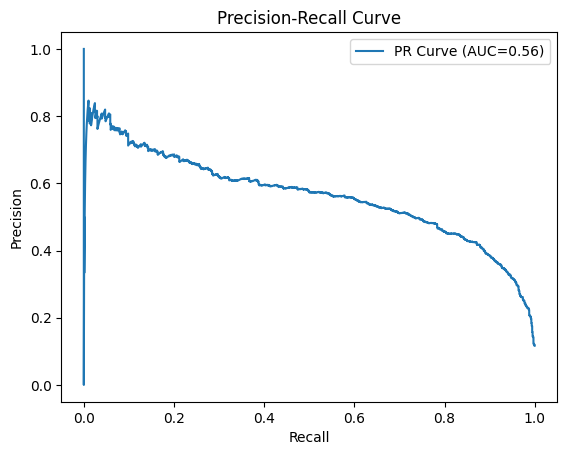

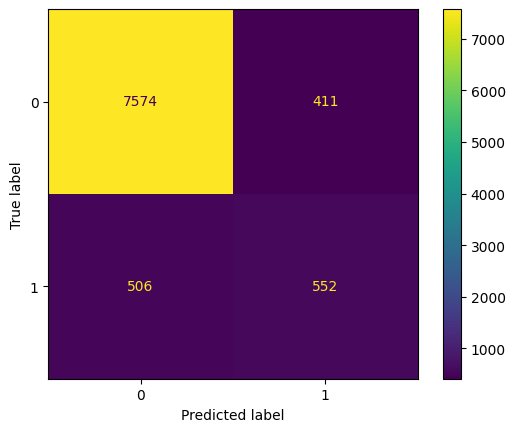

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from imblearn.combine import SMOTETomek
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def split_features_and_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column].map({'no': 0, 'yes': 1})
    return X, y

def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def apply_smote_tomek(X_train, y_train):
    smote_tomek = SMOTETomek(random_state=42)
    return smote_tomek.fit_resample(X_train, y_train)

def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None, class_weight="balanced")
    rf_model.fit(X_train, y_train)
    return rf_model

def train_gradient_boosting(X_train, y_train):
    gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
    gb_model.fit(X_train, y_train)
    return gb_model

def build_and_train_neural_network(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    nn_model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    return nn_model, scaler

def train_stacking_ensemble(X_meta_train, y_meta_train):
    meta_model = LogisticRegression(random_state=42, C=1.0, solver='liblinear', class_weight="balanced")
    meta_model.fit(X_meta_train, y_meta_train)
    return meta_model

def evaluate_stacking_ensemble(meta_model, X_meta_test, y_test):
    y_pred_proba = meta_model.predict_proba(X_meta_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    print("Stacking Ensemble Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Stacking Ensemble ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print("Precision-Recall AUC:", pr_auc)

    # Visualize Precision-Recall Curve
    plt.plot(recall, precision, label=f"PR Curve (AUC={pr_auc:.2f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

def main(df, target_column='y'):
    # Step 1: Split Features and Target
    X, y = split_features_and_target(df, target_column)

    # Step 2: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split_stratified(X, y)

    # Step 3: Apply SMOTE + Tomek Links
    X_train_resampled, y_train_resampled = apply_smote_tomek(X_train, y_train)
    print("Class distribution after SMOTE + Tomek:")
    print(y_train_resampled.value_counts())

    # Step 4: Train Base Models (Random Forest, Gradient Boosting, and Neural Network)
    rf_model = train_random_forest(X_train_resampled, y_train_resampled)
    gb_model = train_gradient_boosting(X_train_resampled, y_train_resampled)
    nn_model, scaler = build_and_train_neural_network(X_train_resampled, y_train_resampled)

    # Step 5: Prepare Meta-Training Data
    rf_meta_train = rf_model.predict_proba(X_train_resampled)[:, 1].reshape(-1, 1)
    rf_meta_test = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

    gb_meta_train = gb_model.predict_proba(X_train_resampled)[:, 1].reshape(-1, 1)
    gb_meta_test = gb_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

    X_train_resampled_scaled = scaler.transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    nn_meta_train = nn_model.predict(X_train_resampled_scaled).ravel().reshape(-1, 1)
    nn_meta_test = nn_model.predict(X_test_scaled).ravel().reshape(-1, 1)

    # Combine Meta-Features
    X_meta_train = np.hstack((rf_meta_train, gb_meta_train, nn_meta_train))
    X_meta_test = np.hstack((rf_meta_test, gb_meta_test, nn_meta_test))

    # Step 6: Train Stacking Meta-Model
    meta_model = train_stacking_ensemble(X_meta_train, y_train_resampled)

    # Step 7: Evaluate Stacking Ensemble
    evaluate_stacking_ensemble(meta_model, X_meta_test, y_test)

# Example usage
main(df_encoded)  # Replace df_encoded with your DataFrame


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Class distribution after SMOTE + Tomek:
y
0    31082
1    31082
Name: count, dtype: int64
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1555/1555 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8869 - loss: 0.2685 - val_accuracy: 0.9818 - val_loss: 0.0596
Epoch 2/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9251 - loss: 0.1758 - val_accuracy: 0.9834 - val_loss: 0.0535
Epoch 3/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9260 - loss: 0.1688 - val_accuracy: 0.9780 - val_loss: 0.0652
Epoch 4/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9281 - loss: 0.1630 - val_accuracy: 0.9859 - val_loss: 0.0474
Epoch 5/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9316 - loss: 0.1580 - val_accuracy: 0.9827 - val_loss: 0.0510
Epoch 6/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9313 - loss: 0.1572 - val_accuracy: 0.9904 - val_loss: 0.0369
Epoch 7/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9336 - loss: 0.1523 - val_accuracy: 0.9808 - val_loss: 0.0575
Epoch 8/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9314 - loss: 0.1567 - val_accurac

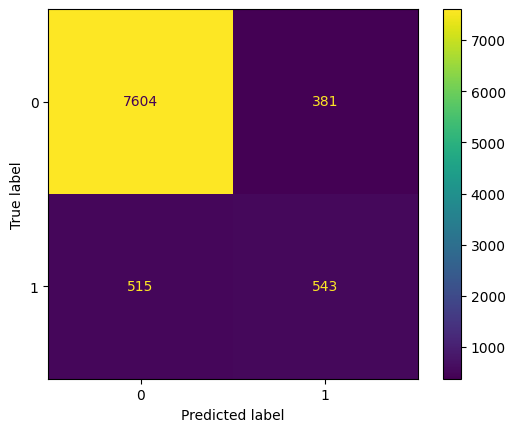

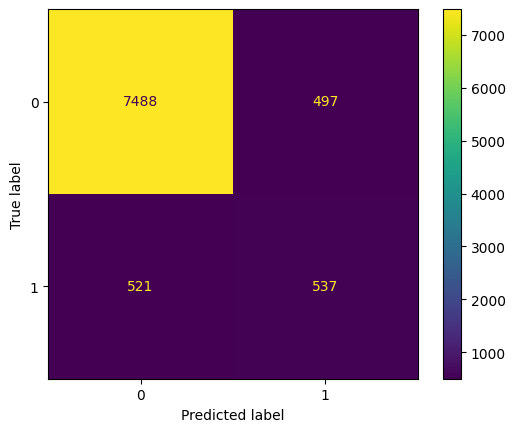

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def split_features_and_target(df, target_column):
    """
    Splits the DataFrame into features and target variable.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the target column.

    Returns:
        X (pd.DataFrame): Features.
        y (pd.Series): Target variable.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column].map({'no': 0, 'yes': 1})
    return X, y

def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets using stratified sampling.

    Parameters:
        X (pd.DataFrame): Features.
        y (pd.Series): Target variable.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def apply_smote_tomek(X_train, y_train):
    """
    Applies SMOTE + Tomek Links to the training data to handle class imbalance.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.

    Returns:
        X_train_resampled, y_train_resampled: Resampled datasets.
    """
    smote_tomek = SMOTETomek(random_state=42)
    return smote_tomek.fit_resample(X_train, y_train)

def train_random_forest(X_train, y_train):
    """
    Trains a Random Forest classifier.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.

    Returns:
        rf_model: Trained Random Forest model.
    """
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

def build_and_train_neural_network(X_train, y_train):
    """
    Builds and trains a Neural Network.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.

    Returns:
        nn_model: Trained Neural Network model.
        scaler: Fitted StandardScaler instance.
    """
    # Scale features for Neural Network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Build Neural Network
    nn_model = Sequential([
        Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification output
    ])

    # Compile the Neural Network
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the Neural Network
    nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

    return nn_model, scaler

def evaluate_model(model, X_test, y_test, scaler=None, model_type='rf'):
    """
    Evaluates the model and prints classification report and ROC-AUC score.

    Parameters:
        model: The trained model (Random Forest or Neural Network).
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        scaler: Fitted StandardScaler instance (for Neural Network).
        model_type (str): Type of model ('rf' for Random Forest, 'nn' for Neural Network).
    """
    if model_type == 'rf':
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif model_type == 'nn':
        X_test_scaled = scaler.transform(X_test)
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"{model_type.upper()} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{model_type.upper()} ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

def main(df, target_column='y'):
    """
    Main function to execute the machine learning workflow.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing features and target.
        target_column (str): The name of the target column.
    """
    # Step 1: Split Features and Target
    X, y = split_features_and_target(df, target_column)

    # Step 2: Train-Test Split (Stratified)
    X_train, X_test, y_train, y_test = train_test_split_stratified(X, y)

    # Step 3: Apply SMOTE + Tomek Links
    X_train_resampled, y_train_resampled = apply_smote_tomek(X_train, y_train)
    print("Class distribution after SMOTE + Tomek:")
    print(y_train_resampled.value_counts())

    # Step 4: Train Random Forest
    rf_model = train_random_forest(X_train_resampled, y_train_resampled)

    # Step 5: Train Neural Network
    nn_model, scaler = build_and_train_neural_network(X_train_resampled, y_train_resampled)

    # Step 6: Evaluate Models
    evaluate_model(rf_model, X_test, y_test, model_type='rf')
    evaluate_model(nn_model, X_test, y_test, scaler=scaler, model_type='nn')

# Example usage
# Assuming df is your DataFrame with the target column named 'y'
main(df_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Class distribution after SMOTE + Tomek:
y
0    30102
1    30102
Name: count, dtype: int64
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1506/1506 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8933 - loss: 0.2572 - val_accuracy: 0.9704 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 2/50
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9264 - loss: 0.1644 - val_accuracy: 0.9791 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 3/50
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9289 - loss: 0.1564 - val_accuracy: 0.9759 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 4/50
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9321 - loss: 0.1491 - val_accuracy: 0.9763 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 5/50
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9321 - loss: 0.1445 - val_accuracy: 0.9787 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 6/50
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9349 - loss: 0.1399 - val_accuracy: 0.9814 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 7/50
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9379 - loss: 0.1339

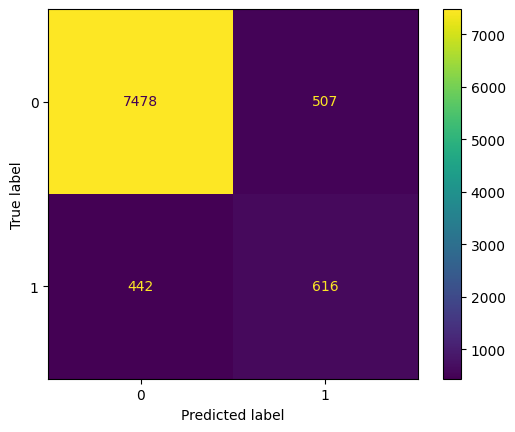

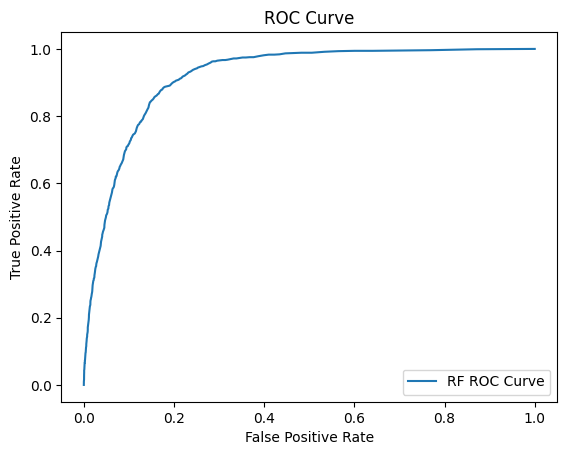

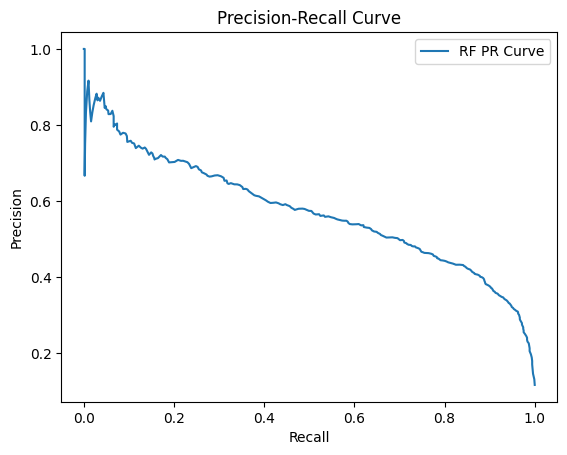

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.54      0.54      0.54      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.74      0.74      9043
weighted avg       0.89      0.89      0.89      9043

NN ROC-AUC Score: 0.9108283134847593


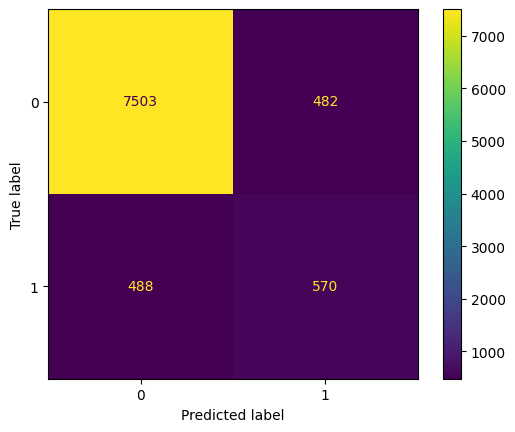

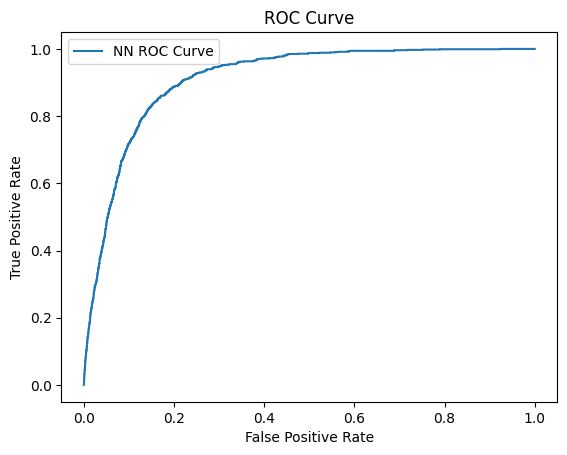

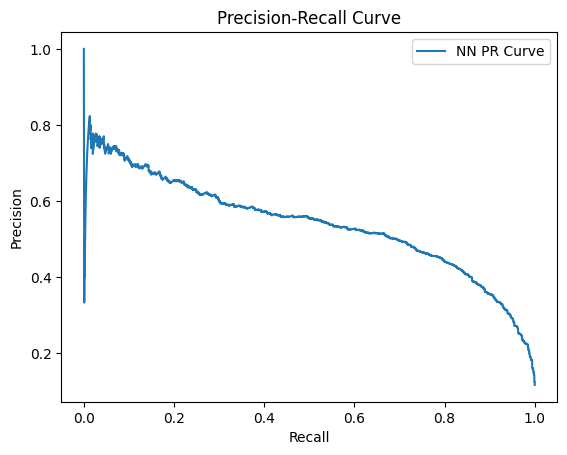

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def split_features_and_target(df, target_column):
    """
    Splits the DataFrame into features and target variable.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column].map({'no': 0, 'yes': 1})
    return X, y

def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets using stratified sampling.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def apply_smote_tomek(X_train, y_train):
    """
    Applies SMOTE + Tomek Links to the training data to handle class imbalance.
    """
    smote_tomek = SMOTETomek(random_state=42)
    return smote_tomek.fit_resample(X_train, y_train)

def feature_engineering(X):
    """
    Adds interaction and polynomial features.
    """
    # Interaction features
    X['balance_duration'] = X['balance'] * X['duration']
    X['age_campaign'] = X['age'] / (X['campaign'] + 1)
    return X

def train_random_forest(X_train, y_train):
    """
    Trains a Random Forest classifier with hyperparameter tuning.
    """
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Random Forest Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

def build_and_train_neural_network(X_train, y_train):
    """
    Builds and trains a Neural Network with callbacks.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    nn_model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2,
                 callbacks=[early_stopping, lr_scheduler])

    return nn_model, scaler

def evaluate_model(model, X_test, y_test, scaler=None, model_type='rf'):
    """
    Evaluates the model and prints classification report, ROC-AUC score, and curves.
    """
    if model_type == 'rf':
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif model_type == 'nn':
        X_test_scaled = scaler.transform(X_test)
        y_pred_proba = model.predict(X_test_scaled).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"{model_type.upper()} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{model_type.upper()} ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_type.upper()} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{model_type.upper()} PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main(df, target_column='y'):
    """
    Main function to execute the machine learning workflow.
    """
    # Step 1: Split Features and Target
    X, y = split_features_and_target(df, target_column)

    # Step 2: Train-Test Split (Stratified)
    X_train, X_test, y_train, y_test = train_test_split_stratified(X, y)

    # Step 3: Feature Engineering
    X_train = feature_engineering(X_train)
    X_test = feature_engineering(X_test)

    # Step 4: Apply SMOTE + Tomek Links
    X_train_resampled, y_train_resampled = apply_smote_tomek(X_train, y_train)
    print("Class distribution after SMOTE + Tomek:")
    print(y_train_resampled.value_counts())

    # Step 5: Train Random Forest
    rf_model = train_random_forest(X_train_resampled, y_train_resampled)

    # Step 6: Train Neural Network
    nn_model, scaler = build_and_train_neural_network(X_train_resampled, y_train_resampled)

    # Step 7: Evaluate Models
    evaluate_model(rf_model, X_test, y_test, model_type='rf')
    evaluate_model(nn_model, X_test, y_test, scaler=scaler, model_type='nn')

# Example usage
# Assuming df_encoded is your preprocessed DataFrame
main(df_encoded)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Class distribution after SMOTE + Tomek:
y
0    31081
1    31081
Name: count, dtype: int64
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8941 - loss: 0.2511 - val_accuracy: 0.9716 - val_loss: 0.0742
Epoch 2/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9242 - loss: 0.1680 - val_accuracy: 0.9780 - val_loss: 0.0571
Epoch 3/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9273 - loss: 0.1606 - val_accuracy: 0.9743 - val_loss: 0.0659
Epoch 4/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9298 - loss: 0.1532 - val_accuracy: 0.9793 - val_loss: 0.0524
Epoch 5/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9309 - loss: 0.1504 - val_accuracy: 0.9782 - val_loss: 0.0532
Epoch 6/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9357 - loss: 0.1437 - val_accuracy: 0.9753 - val_loss: 0.0554
Epoch 7/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9383 - loss: 0.1403 - val_accuracy: 0.9768 - val_loss: 0.0529
Epoch 8/50
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9378 - loss: 0.1372 - val_accurac

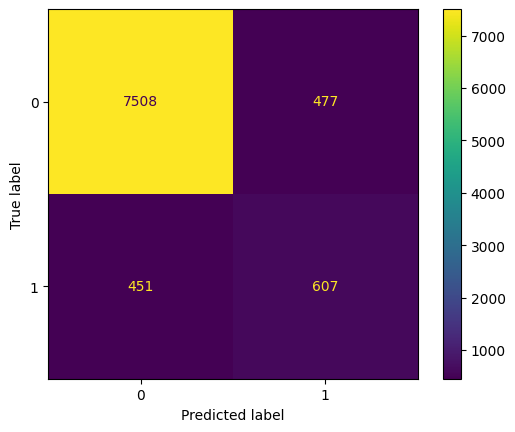

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek
import numpy as np

def split_features_and_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column].map({'no': 0, 'yes': 1})
    return X, y

def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def apply_smote_tomek(X_train, y_train):
    smote_tomek = SMOTETomek(random_state=42)
    return smote_tomek.fit_resample(X_train, y_train)

def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

def build_and_train_neural_network(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    nn_model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    from tensorflow.keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    return nn_model, scaler

def train_stacking_ensemble(X_train, y_train, X_meta_train, y_meta_train):
    """
    Trains a meta-model (stacking ensemble) using outputs of base models.
    """
    meta_model = LogisticRegression(random_state=42)
    meta_model.fit(X_meta_train, y_meta_train)
    return meta_model

def evaluate_stacking_ensemble(meta_model, X_meta_test, y_test):
    """
    Evaluates the stacking ensemble model.
    """
    y_pred_proba = meta_model.predict_proba(X_meta_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    print("Stacking Ensemble Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Stacking Ensemble ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

def main(df, target_column='y'):
    # Step 1: Split Features and Target
    X, y = split_features_and_target(df, target_column)

    # Step 2: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split_stratified(X, y)

    # Step 3: Apply SMOTE + Tomek Links
    X_train_resampled, y_train_resampled = apply_smote_tomek(X_train, y_train)
    print("Class distribution after SMOTE + Tomek:")
    print(y_train_resampled.value_counts())

    # Step 4: Train Base Models (Random Forest and Neural Network)
    rf_model = train_random_forest(X_train_resampled, y_train_resampled)
    nn_model, scaler = build_and_train_neural_network(X_train_resampled, y_train_resampled)

    # Step 5: Prepare Meta-Training Data
    # Random Forest Predictions
    rf_meta_train = rf_model.predict_proba(X_train_resampled)[:, 1].reshape(-1, 1)
    rf_meta_test = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

    # Neural Network Predictions
    X_train_resampled_scaled = scaler.transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    nn_meta_train = nn_model.predict(X_train_resampled_scaled).ravel().reshape(-1, 1)
    nn_meta_test = nn_model.predict(X_test_scaled).ravel().reshape(-1, 1)

    # Combine Meta-Features
    X_meta_train = np.hstack((rf_meta_train, nn_meta_train))
    X_meta_test = np.hstack((rf_meta_test, nn_meta_test))

    # Step 6: Train Stacking Meta-Model
    meta_model = train_stacking_ensemble(X_train_resampled, y_train_resampled, X_meta_train, y_train_resampled)

    # Step 7: Evaluate Stacking Ensemble
    evaluate_stacking_ensemble(meta_model, X_meta_test, y_test)

# Example usage
main(df_encoded)


In [23]:
from imblearn.combine import SMOTEENN
import pandas as pd

def split_features_and_target(df, target_column='y'):
    """
    Splits the dataset into features and target.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column].map({'no': 0, 'yes': 1})  # Convert target to binary
    return X, y

def apply_smote_enn(X, y):
    """
    Applies SMOTE-ENN for class balancing.
    """
    smote_enn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X, y)
    return X_resampled, y_resampled

# Load your dataset
# Assuming `df_encoded` is the preprocessed dataset with the target column named 'y'
df = df_encoded

# Step 1: Split Features and Target
X, y = split_features_and_target(df)

# Step 2: Apply SMOTE-ENN for Balancing
X_resampled, y_resampled = apply_smote_enn(X, y)

# Step 3: Verify Class Distribution
print("Class distribution before balancing:")
print(y.value_counts())

print("Class distribution after balancing:")
print(pd.Series(y_resampled).value_counts())


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Class distribution before balancing:
y
0    39922
1     5289
Name: count, dtype: int64
Class distribution after balancing:
y
1    34536
0    27947
Name: count, dtype: int64
